

This notebook goes through a **minimal end‑to‑end pipeline**:

1. Dataset inspection & train/val split  
2. Log‑Mel spectrogram extraction with **torchaudio**  
3. A *tiny* CNN baseline in **PyTorch**  
4. Training / validation loop skeleton  
5. Saving predictions for Kaggle


## 1. Configuration

In [22]:
# paths & basic config
from pathlib import Path

# Adjust this to wherever you placed the unzipped dataset
DATA_ROOT = Path.cwd() / "elec378 sp25 dataset" / "elec378 sp25 dataset"
CSV_PATH  = DATA_ROOT / "train.csv"      # will be auto‑created below

SAMPLE_RATE = 22_050
N_MELS      = 64
BATCH_SIZE  = 32
NUM_EPOCHS  = 2
NUM_WORKERS = 0     # set to 0 on Windows if you hit issues

## 2. Build or Load `train.csv`

In [23]:
# --- 1. Create train.csv (file_path, label) if it doesn't exist -----------
import pandas as pd, os, re

if not CSV_PATH.exists():
    rows = []
    for cls_dir in sorted(p for p in DATA_ROOT.iterdir() if p.is_dir()):
        label = cls_dir.name   # 'Angry', 'Happy', ...
        for wav in cls_dir.glob("*.wav"):
            rows.append({"path": str(wav), "label": label})
    df = pd.DataFrame(rows)
    df.to_csv(CSV_PATH, index=False)
    print("Wrote", CSV_PATH, "with", len(df), "rows")
else:
    df = pd.read_csv(CSV_PATH)
    print("Loaded", len(df), "rows from", CSV_PATH)
df.head()

Loaded 12798 rows from /Users/aaroncole/Documents/Education/Computer Science/ELEC 378 — Machine Learning Concepts and Techniques/Final Project/elec378 sp25 dataset/elec378 sp25 dataset/train.csv


,path,label
0,/Users/aaroncole/Documents/Education/Computer ...,Angry
1,/Users/aaroncole/Documents/Education/Computer ...,Angry
2,/Users/aaroncole/Documents/Education/Computer ...,Angry
3,/Users/aaroncole/Documents/Education/Computer ...,Angry
4,/Users/aaroncole/Documents/Education/Computer ...,Angry


In [24]:
# import pandas as pd
# from pathlib import Path
#
# # Set dataset path
# DATA_ROOT = Path.cwd() / "elec378 sp25 dataset" / "elec378 sp25 dataset"
# CSV_PATH = DATA_ROOT / "train.csv"
#
# # Build the list of (path, label) pairs
# rows = []
# for cls_dir in sorted(p for p in DATA_ROOT.iterdir() if p.is_dir()):
#     label = cls_dir.name
#     for wav_file in cls_dir.glob("*.wav"):
#         if wav_file.is_file():
#             rows.append({"path": str(wav_file), "label": label})
#
# # Save to CSV
# if rows:
#     df = pd.DataFrame(rows)
#     df.to_csv(CSV_PATH, index=False)
#     print(f"✅ Wrote {CSV_PATH} with {len(df)} rows")
#     display(df.head())
# else:
#     print("⚠️ No .wav files found in the subdirectories.")

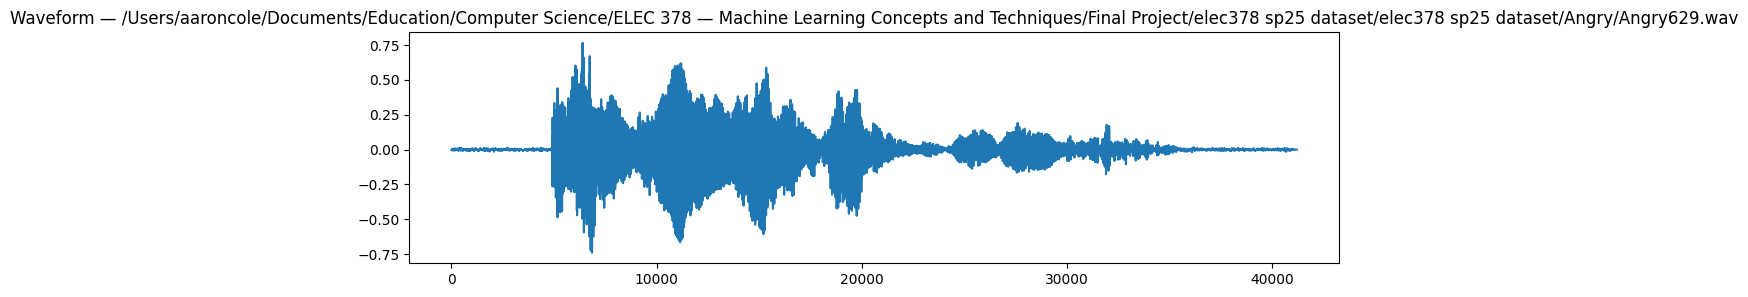

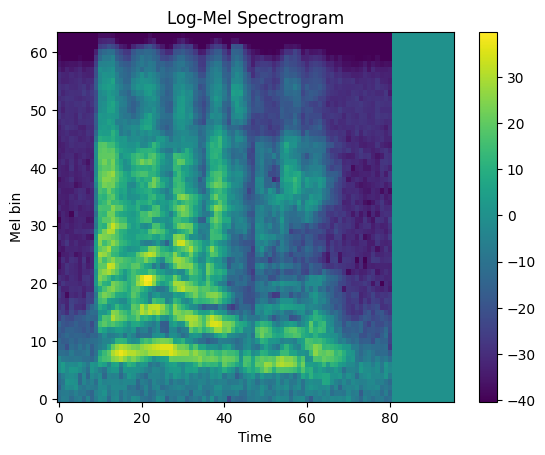

In [25]:
import torchaudio
import matplotlib.pyplot as plt

# Test first sample
sample_path = df.iloc[0]['path']
wave, sr = torchaudio.load(sample_path)
if sr != 22_050:
    wave = torchaudio.functional.resample(wave, sr, 22_050)

plt.figure(figsize=(12, 3))
plt.title(f"Waveform — {sample_path}")
plt.plot(wave.t().numpy())
plt.show()

# Compute and display log-mel spectrogram
mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=22_050, n_fft=1024, hop_length=512, n_mels=64)
to_db = torchaudio.transforms.AmplitudeToDB(top_db=80)

mel = mel_spec(wave.mean(0))
logmel = to_db(mel)

desired_frames = 96
if logmel.shape[-1] < desired_frames:
    pad_amt = desired_frames - logmel.shape[-1]
    logmel = F.pad(logmel, (0, pad_amt))
else:
    logmel = logmel[:, :, :desired_frames]

plt.imshow(logmel.numpy(), origin='lower', aspect='auto')
plt.title("Log-Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel bin")
plt.colorbar()
plt.show()

## 3. Quick Exploratory Visualization

label
Test         2557
Angry        1734
Happy        1734
Sad          1734
Fearful      1638
Disgusted    1491
Neutral      1436
Suprised      474
Name: count, dtype: int64


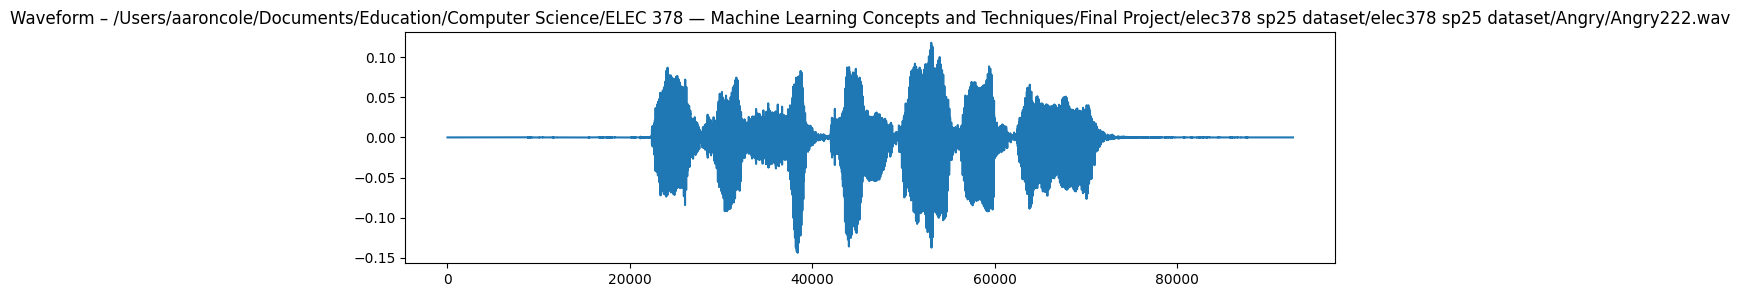

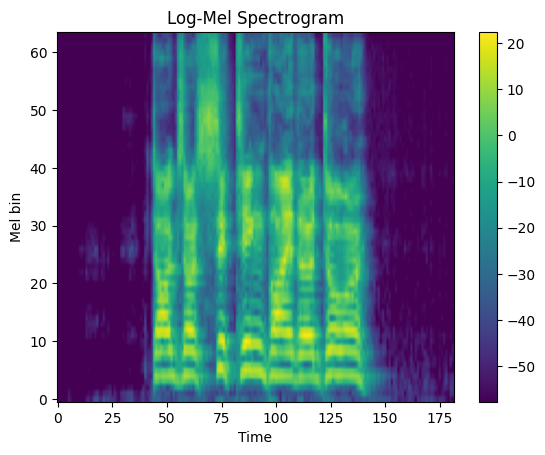

In [26]:
# --- 2. Quick data exploration ------------------------------------------
import matplotlib.pyplot as plt, torchaudio, random

label_counts = df['label'].value_counts()
print(label_counts)

# listen to a random sample & plot waveform + log‑mel
sample_path = random.choice(df['path'].tolist())
wave, sr = torchaudio.load(sample_path)
if sr != SAMPLE_RATE:
    wave = torchaudio.functional.resample(wave, sr, SAMPLE_RATE)
plt.figure(figsize=(12,3))
plt.title(f"Waveform – {sample_path}")
plt.plot(wave.t().numpy())
plt.show()

mel = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,
                                           n_fft=1024,
                                           hop_length=512,
                                           n_mels=N_MELS)(wave.mean(0))
logmel = torchaudio.transforms.AmplitudeToDB(top_db=80)(mel)
plt.imshow(logmel.numpy(), origin='lower', aspect='auto')
plt.title("Log‑Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel bin")
plt.colorbar()
plt.show()

## 4. PyTorch Dataset & DataLoaders

In [27]:
# --- 3. PyTorch Dataset ---------------------------------------------------
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio

mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,
                                                n_fft=1024,
                                                hop_length=512,
                                                n_mels=N_MELS)
to_db = torchaudio.transforms.AmplitudeToDB(top_db=80)

class EmotionWav(Dataset):
    def __init__(self, dataframe, segment_sec=None):
        self.df = dataframe.reset_index(drop=True)
        self.segment_sec = segment_sec
        self.label2idx = {lbl:i for i,lbl in enumerate(sorted(self.df['label'].unique()))}
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row   = self.df.iloc[idx]
        path  = row['path']
        label = self.label2idx[row['label']]
        wave, sr = torchaudio.load(path)
        if sr != SAMPLE_RATE:
            wave = torchaudio.functional.resample(wave, sr, SAMPLE_RATE)
        if wave.shape[0] > 1:      # stereo → mono
            wave = wave.mean(0, keepdim=True)
        if self.segment_sec:
            seg_samples = int(self.segment_sec * SAMPLE_RATE)
            if wave.shape[1] > seg_samples:
                start = torch.randint(0, wave.shape[1]-seg_samples, (1,)).item()
                wave = wave[:, start:start+seg_samples]

        mel = to_db(mel_spec(wave))  # (1, n_mels, time)

        # Ensure consistent time dimension
        desired_frames = 96
        if mel.shape[-1] < desired_frames:
            mel = F.pad(mel, (0, desired_frames - mel.shape[-1]))
        else:
            mel = mel[:, :, :desired_frames]      # (1, n_mels, time)
        return mel, label

In [28]:
# split into train/val sets stratified by label
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

train_ds = EmotionWav(train_df, segment_sec=3)
val_ds   = EmotionWav(val_df,   segment_sec=3)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=False)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=False)

print(f"Train batches: {len(train_dl)} | Val batches: {len(val_dl)}")

Train batches: 360 | Val batches: 40


## 5. Tiny CNN Baseline

In [29]:
# --- 4. A *very* small CNN baseline ---------------------------------------
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim

class TinyCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,   16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,  32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,  64, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1),
            nn.Flatten(), nn.Linear(64, n_classes)
        )
    def forward(self, x): return self.net(x)

N_CLASSES = train_ds.__len__() and len(train_ds.label2idx)
model = TinyCNN(N_CLASSES).to('cuda' if torch.cuda.is_available() else 'cpu')
print(model)

TinyCNN(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=1)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=64, out_features=8, bias=True)
  )
)


In [30]:
import torch
print("MPS available:", torch.backends.mps.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

MPS available: True
Device: cpu


## 6. Training Loop

In [31]:
# --- 5. Training / validation loop skeleton -------------------------------
# device = next(model.parameters()).device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print("MPS available:", torch.backends.mps.is_available())
print("Using device:", device)

model = TinyCNN(N_CLASSES).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    train_loss, train_correct = 0, 0
    for i, (xb, yb) in enumerate(train_dl):
        xb, yb = xb.to(device).float(), yb.to(device)  # ensure float() on M1/M2/M4
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * len(yb)
        train_correct += (out.argmax(1) == yb).sum().item()

        # Print every N batches
        print(f"Epoch {epoch}, Batch {i}/{len(train_dl)} — Loss: {loss.item():.4f}")

    train_loss /= len(train_ds)
    train_acc  = train_correct / len(train_ds)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            val_loss += loss.item()*len(yb)
            val_correct += (out.argmax(1)==yb).sum().item()
    val_loss /= len(val_ds)
    val_acc  = val_correct / len(val_ds)

    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.3f}")

MPS available: True
Using device: mps
Epoch 1, Batch 0/360 — Loss: 2.2674
Epoch 1, Batch 1/360 — Loss: 2.1712
Epoch 1, Batch 2/360 — Loss: 2.1886
Epoch 1, Batch 3/360 — Loss: 2.1741
Epoch 1, Batch 4/360 — Loss: 2.0815
Epoch 1, Batch 5/360 — Loss: 2.1146
Epoch 1, Batch 6/360 — Loss: 2.0745
Epoch 1, Batch 7/360 — Loss: 2.0552
Epoch 1, Batch 8/360 — Loss: 2.0748
Epoch 1, Batch 9/360 — Loss: 2.0216
Epoch 1, Batch 10/360 — Loss: 2.0614
Epoch 1, Batch 11/360 — Loss: 1.9530
Epoch 1, Batch 12/360 — Loss: 2.0273
Epoch 1, Batch 13/360 — Loss: 2.0051
Epoch 1, Batch 14/360 — Loss: 1.9631
Epoch 1, Batch 15/360 — Loss: 1.9748
Epoch 1, Batch 16/360 — Loss: 2.0575
Epoch 1, Batch 17/360 — Loss: 2.0370
Epoch 1, Batch 18/360 — Loss: 2.0294
Epoch 1, Batch 19/360 — Loss: 2.0079
Epoch 1, Batch 20/360 — Loss: 1.9185
Epoch 1, Batch 21/360 — Loss: 1.9086
Epoch 1, Batch 22/360 — Loss: 1.9129
Epoch 1, Batch 23/360 — Loss: 2.0036
Epoch 1, Batch 24/360 — Loss: 1.8095
Epoch 1, Batch 25/360 — Loss: 1.9621
Epoch 1, B

## 7. Save Model & Label Map

In [32]:
# --- 6. Save model & label map -------------------------------------------
OUT_DIR = Path.cwd()
torch.save(model.state_dict(), OUT_DIR / "tinycnn_state_dict.pt")
import json, pickle
with open(OUT_DIR / "label2idx.json", "w") as f:
    json.dump(train_ds.label2idx, f)
print("Saved model & label map to", OUT_DIR)

Saved model & label map to /Users/aaroncole/Documents/Education/Computer Science/ELEC 378 — Machine Learning Concepts and Techniques/Final Project


## 8. Create Kaggle Submission

In [45]:
from torch.utils.data import Dataset

# Set up test data paths
TEST_DIR = DATA_ROOT / "Test"
test_paths = list(TEST_DIR.glob("*.wav"))
test_df = pd.DataFrame({"path": [str(p) for p in test_paths]})

# Create a special test-only Dataset (no labels)
class EmotionWavTest(Dataset):
    def __init__(self, dataframe, segment_sec=None):
        self.df = dataframe.reset_index(drop=True)
        self.segment_sec = segment_sec

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['path']
        wave, sr = torchaudio.load(path)
        if sr != SAMPLE_RATE:
            wave = torchaudio.functional.resample(wave, sr, SAMPLE_RATE)
        if wave.shape[0] > 1:
            wave = wave.mean(0, keepdim=True)
        if self.segment_sec:
            seg_samples = int(self.segment_sec * SAMPLE_RATE)
            if wave.shape[1] > seg_samples:
                start = torch.randint(0, wave.shape[1] - seg_samples, (1,)).item()
                wave = wave[:, start:start + seg_samples]

        mel = to_db(mel_spec(wave))
        desired_frames = 96
        if mel.shape[-1] < desired_frames:
            mel = F.pad(mel, (0, desired_frames - mel.shape[-1]))
        else:
            mel = mel[:, :, :desired_frames]
        return mel

# Run inference
model.eval()
preds = []
with torch.no_grad():
    for xb in DataLoader(EmotionWavTest(test_df, segment_sec=3), batch_size=BATCH_SIZE):
        xb = xb.to(device)
        out = model(xb)
        preds.extend(out.argmax(1).cpu().tolist())

# Map index to label
idx2label = {v: k for k, v in train_ds.label2idx.items()}
# Extract only the filename (e.g., "2217.wav")
test_df['filename'] = test_df['path'].apply(lambda p: Path(p).name)

# Map predictions to emotion strings
test_df['emotion'] = [idx2label[i] for i in preds]

# # Select only required columns
# submission_df = test_df[['filename', 'emotion']]
# submission_df.to_csv("submission.csv", index=False)
# print("✅ Wrote submission.csv")

✅ Wrote submission.csv


In [49]:
from pathlib import Path

# Drop the 'path' column if it exists
if 'path' in test_df.columns:
    test_df = test_df.drop(columns='path')

# Ensure filenames are just the base name (in case they aren't yet)
test_df['filename'] = test_df['filename'].apply(lambda p: Path(p).name)

# Sort numerically by stripping ".wav" and converting to int
test_df['file_num'] = test_df['filename'].str.replace('.wav', '', regex=False).astype(int)
test_df = test_df.sort_values('file_num').drop(columns='file_num').reset_index(drop=True)

# Keep only filename and emotion
test_df = test_df[['filename', 'emotion']]

# Optional: preview
print(test_df.head())

  filename    emotion
0    1.wav  Disgusted
1    2.wav      Angry
2    3.wav      Happy
3    4.wav    Fearful
4    5.wav    Neutral


In [50]:
from pathlib import Path

# STEP 1 — Remove 'path' column if it exists
if 'path' in test_df.columns:
    test_df = test_df.drop(columns='path')

# STEP 2 — Ensure filenames are just base names (no full paths)
test_df['filename'] = test_df['filename'].apply(lambda p: Path(p).name)

# STEP 3 — Add numeric sort key based on filename (e.g., "1.wav" → 1)
test_df['file_num'] = test_df['filename'].str.replace('.wav', '', regex=False).astype(int)

# STEP 4 — Sort and clean up
test_df = test_df.sort_values('file_num').drop(columns='file_num').reset_index(drop=True)

# STEP 5 — Keep only filename and emotion
test_df = test_df[['filename', 'emotion']]

# STEP 6 — Save as submission.csv
test_df.to_csv("submission.csv", index=False)
print("✅ Saved submission.csv in required format.")

✅ Saved submission.csv in required format.


In [48]:
test_df

,path,filename,emotion
0,/Users/aaroncole/Documents/Education/Computer ...,2217.wav,Test
1,/Users/aaroncole/Documents/Education/Computer ...,1078.wav,Test
2,/Users/aaroncole/Documents/Education/Computer ...,2203.wav,Happy
3,/Users/aaroncole/Documents/Education/Computer ...,1722.wav,Sad
4,/Users/aaroncole/Documents/Education/Computer ...,1044.wav,Fearful
...,...,...,...
2552,/Users/aaroncole/Documents/Education/Computer ...,1713.wav,Angry
2553,/Users/aaroncole/Documents/Education/Computer ...,1075.wav,Test
2554,/Users/aaroncole/Documents/Education/Computer ...,1061.wav,Test
2555,/Users/aaroncole/Documents/Education/Computer ...,1707.wav,Test
